In [241]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Make clicks stimulus

NameError: name 'right_ind' is not defined

In [365]:
def make_clicktrain(right_rate=30, total_rate=40, duration=1,  dt=.001, stereo_click=True):
    """Generate Poisson Click train"""
    if stereo_click:
        raise notImplementedError
    tvec = np.arange(0, duration, dt)
    left_rate = total_rate - right_rate
    right_ind = np.random.random_sample(np.shape(tvec)) < (right_rate * dt)
    left_ind = np.random.random_sample(np.shape(tvec)) < (left_rate * dt)    
    
    if stereo_click:
        first_ind = np.argwhere(right_ind+left_ind>0)[0]
        right_ind[first_ind] = 1
        left_ind[first_ind] = 1
    
    left_bups = tvec[left_ind]
    right_bups = tvec[right_ind]
    
    fig, ax = plt.subplots( figsize=(4,2))
    ax1 = ax
    ax1.eventplot(left_bups,lineoffsets=-.5,color="blue", alpha=.5)
    ax1.eventplot(right_bups,lineoffsets=.5,color="red", alpha=.5)
    ax1.plot(left_bups,-np.ones_like(left_bups), "o", color="blue", alpha=.5)
    ax1.plot(right_bups,np.ones_like(right_bups), "o", color="red", alpha=.5)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Clicks")
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    bups = {'left':left_bups, 'right':right_bups, 'tvec':tvec}
    
    return bups

In [366]:
# adapt the clicks
def make_adapted_clicks(bups, phi=.1, tau_phi=.2, cross_stream=True):
    if not cross_stream:
        raise notImplementedError
    bups_cat = np.hstack([bups['left'], bups['right']])
    sign_cat = np.hstack([-np.ones_like(bups['left']), np.ones_like(bups['right'])])
    sort_order = np.argsort(bups_cat)
    bups_cat = bups_cat[sort_order]
    sign_cat = sign_cat[sort_order]

    ici = np.diff(bups_cat)
    adapted  = np.ones_like(bups_cat)

    cross_side_suppression = 0
    for ii in np.arange(1,len(adapted)):
        if ici[ii-1] <= cross_side_suppression:
            adapted[ii-1] = 0
            adapted[ii] = 0
            continue
        if abs(phi-1) > 1e-5:
            last = tau_phi  * np.log(abs(1 - adapted[ii-1] * phi))
            adapted[ii] = 1 - np.exp((-ici[ii-1] + last) / tau_phi)

    left_adapted = adapted[sign_cat==-1]
    right_adapted = adapted[sign_cat==1]
    bups['left_adapted'] = left_adapted
    bups['right_adapted'] = right_adapted

    left_bups = bups['left']
    right_bups = bups['right']
    
    fig, ax = plt.subplots( figsize=(4,2))
    ax1 = ax
    ax1.plot(np.vstack([left_bups, left_bups]), 
             np.vstack([np.zeros_like(left_bups), -left_adapted]), color="blue", alpha=.5)
    ax1.plot(np.vstack([right_bups, right_bups]), 
             np.vstack([np.zeros_like(right_bups), right_adapted]), color="red", alpha=.5)
    
    ax1.plot(left_bups,-left_adapted, "o", color="blue", alpha=.5)
    ax1.plot(right_bups,right_adapted, "o", color="red", alpha=.5)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Clicks")
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    return None



In [367]:
w = interactive(make_clicktrain, #{'manual': True},
                right_rate=(0,40), duration=(0,9,.1), dt=(.001,.1,.01), total_rate=(5,40))
display(w)



interactive(children=(IntSlider(value=30, description='right_rate', max=40), IntSlider(value=40, description='…

In [364]:
bups = w.result
w2 = interactive(make_adapted_clicks, #{'manual': True},
                bups=fixed(bups), phi=(0.01,1.5,.01), tau_phi=(.01,1,.01))
display(w2)

interactive(children=(FloatSlider(value=0.1, description='phi', max=1.5, min=0.01, step=0.01), FloatSlider(val…

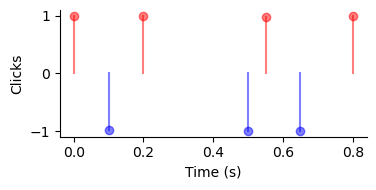

(array([0.98160603, 0.99810079, 0.99285315]),
 array([1.        , 0.98871113, 0.97088299, 0.9905179 ]))

In [359]:
bups_copy = bups.copy()
bups['left'] = [.1, .5, .65]
bups['right'] = [.0, .2, .55, .8]
make_adapted_clicks(bups, phi=1.05, tau_phi = .1)
bups['left_adapted'], bups['right_adapted']

## How does the adaptation work

$\frac{dC}{dt} = \frac{1-C}{\tau_{\phi}} + (\phi - 1) C (\delta_{t,t_R} + \delta_{t,t_L})$

In [ ]:
phi = .05
tau_phi = .1
C = (1 - C[ii-1]) / tau_phi + (phi - 1) * C[ii-1] * (left+right)

In [ ]:
# Redo clicks to take in the gamma and total rate and print the generative rates

In [ ]:
# Make the bups stay synced when it changes

In [ ]:
# Add stereo click 
# Make adaptation work for positive values of phi

In [130]:
# TODO add the time constant
# TODO add some noise
# TODO add the 

SyntaxError: invalid syntax (104630642.py, line 1)

In [ ]:
# make tests
# put it on the internet


In [ ]:
# add multiple trials
# add a bound